# tikreg tutorial: Non-spherical multivariate normal priors on temporal delays

`tikreg`: https://github.com/gallantlab/tikreg

This example follows Figure 2 from [Nunez-Elizalde, et al., 2019.](https://www.sciencedirect.com/science/article/pii/S1053811919302988?via%3Dihub)

We'll be using data from a vision experiment (Nishimoto, et al., 2011). 

## Requirements

In addition to `tikreg`, you'll need to install `h5py` to load the example data used in this tutorial and `matplotlib` to display the figures.

Uncomment the following line install the requirements:

In [1]:
#!pip install tikreg==0.0.1 h5py matplotlib

Get the data from this link (~250MB): https://drive.google.com/open?id=1fcYosXaGsdS3u1xj8NMIC6ytEUbXMuGj.

Once downloaded, unzip the file contents and write the location:

In [2]:
# Location of the unzipped data
root_directory = '.' # defaults to current working directory

In [3]:
## On linux (and maybe macs), you can use the following to download and unzip the data
## (from: https://gist.github.com/iamtekeste/3cdfd0366ebfd2c0d805#gistcomment-2316906)

if 0: # Change to 1 if running on e.g. Binder or Google Colab
    import os
    flname = 'tikreg_demodata.zip'
    unzipped_folder = 'tiny_vision'
    cmd = r'''wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILEID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILEID}" -O {FILENAME} && rm -rf /tmp/cookies.txt'''
    if not os.path.exists(flname) and not os.path.exists(unzipped_folder):
        os.system(cmd.format(FILEID='1fcYosXaGsdS3u1xj8NMIC6ytEUbXMuGj',FILENAME=flname))
    os.system('unzip -u tikreg_demodata.zip')

## Start

In [4]:
%matplotlib inline

In [5]:
import os

import numpy as np
np.random.seed(1337)
np.set_printoptions(precision=4, suppress=True)

from scipy.stats import zscore
from matplotlib import pyplot as plt
plt.style.use('default')

import h5py
from tikreg import models, utils as tikutils
from tikreg import spatial_priors, temporal_priors

In [6]:
path = os.path.join(root_directory, 'tiny_vision')

features_file = os.path.join(path, 'features', 'motion_energy.hdf')
responses_file = os.path.join(path, 'responses', 'S1.hdf')
voxels_file = os.path.join(path, 'rois', 'S1.hdf')

In [7]:
def hdf_load(hdf_file, key):
    '''Load data from an HDF5 file
    '''
    assert os.path.exists(hdf_file)
    
    with h5py.File(hdf_file, 'r') as hfl:
        hdf_content = hfl.keys()
        assert key in hdf_content
        return np.asarray(hfl[key])
    

def plot_model_2dhist_comparison(corrs1, corrs2, 
                                 name1='corrs1', name2='corrs2', cmap='inferno',
                                 ax=None, lims=(-0.5, 1.0), nbins=100, 
                                 title='model comparison\n(prediction accuracy [$r$])'):
    '''Histogram of prediction accuracy from two models
    
    Parameters
    ----------
    corrs1, corrs2 : np.ndarray (N,)
        Data to plot along the horizontal (corrs1) and vertical (corrs2) dimension
    '''
    colormap = plt.cm.get_cmap(cmap)
    
    lo, hi = lims
    bins = np.linspace(lo, hi, nbins)
    h, xe, ye = np.histogram2d(corrs2,
                               corrs1,
                               bins=bins)

    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)

    im = ax.imshow(np.log(h), origin="lower", extent=(lo, hi, lo, hi), cmap=colormap, interpolation='nearest')
    ax.plot([lo, hi], [lo, hi], 'k-')
    ax.axis([lo, hi, lo, hi])


    ax.plot([0, 0], [lo, hi], color="0.1", linestyle=":")
    ax.plot([lo, hi], [0, 0], color="0.1", linestyle=":")

    ax.set_ylabel("%s model" % name2, fontsize=15)
    ax.set_xlabel("%s model" % name1, fontsize=15)

    cbar = plt.colorbar(im, orientation='vertical')
    cbar.set_label('voxel density [$log_{10}$]', fontsize=15)
    _ = ax.set_title(title, fontsize=20)
    return ax


def symmatshow(mat, ax=None, cbar=True, cmap='coolwarm', **kwargs):
    '''Display a matrix with values centered at zero
    '''
    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)
                         
    matmin = np.nanmin(mat)
    matmax = np.nanmax(mat)
    vmax = np.max([np.abs(matmin), np.abs(matmax)])
    im = ax.matshow(mat, cmap=cmap, vmin=-vmax, vmax=vmax, **kwargs)
    if cbar:
        cb = plt.colorbar(im, orientation='vertical')
    return ax

In [8]:
Xtrain = hdf_load(features_file, 'train')
Xtest = hdf_load(features_file, 'test')
print(Xtrain.shape, Xtest.shape)

(3600, 6555) (270, 6555)


In [9]:
Ytrain = hdf_load(responses_file, 'train')
Ytest = hdf_load(responses_file, 'test')
print(Ytrain.shape, Ytest.shape)

(3600, 2650) (270, 2650)


In [10]:
nfeatures = Xtrain.shape[1]
delays = np.arange(10)

In [11]:
feature_prior = spatial_priors.SphericalPrior(nfeatures)
temporal_prior = temporal_priors.SphericalPrior(delays=delays)

In [12]:
fit_spherical = models.estimate_stem_wmvnp([Xtrain], Ytrain, 
                                           [Xtest],Ytest,
                                           feature_priors=[feature_prior],
                                           temporal_prior=temporal_prior,
                                           ridges=np.logspace(0,4,10),
                                           folds=(1,5),
                                           performance=True,
                                           population_optimal=False,
                                           verbosity=2)

1/1: temporal 1/1=0.000, features 1/1=(1.0000, )
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1949, (25,50,75)pctl=(0.0779,0.1668,0.2969),(0.0<r>0.5): (2553,071)
lambda 02:    2.783, mean=0.1949, (25,50,75)pctl=(0.0780,0.1668,0.2970),(0.0<r>0.5): (2553,071)
lambda 03:    7.743, mean=0.1953, (25,50,75)pctl=(0.0782,0.1672,0.2975),(0.0<r>0.5): (2554,072)
lambda 04:   21.544, mean=0.1979, (25,50,75)pctl=(0.0798,0.1698,0.3017),(0.0<r>0.5): (2553,078)
lambda 05:   59.948, mean=0.2107, (25,50,75)pctl=(0.0879,0.1835,0.3207),(0.0<r>0.5): (2557,110)
lambda 06:  166.810, mean=0.2388, (25,50,75)pctl=(0.1062,0.2195,0.3633),(0.0<r>0.5): (2572,188)
lambda 07:  464.159, mean=0.2530, (25,50,75)pctl=(0.1258,0.2416,0.3741),(0.0<r>0.5): (2587,191)
lambda 08: 1291.550, mean=0.2322, (25,50,75)pctl=(0.1213,0.2235,0.3363),(0.0<r>0.5): (2585,086)
lambda 09: 3593.814, mean=0.1973, (25,50,75)pctl=(0.0979,0.1846,0.2895),(0.0<r>0.5): (2547,014)
lambda 10: 10000.000, mean=0.1800, (25,50,75)pc

/home/anunez/.local/lib/python3.6/site-packages/tikreg/models.py:1178: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  unique_optima = np.vstack(set(tuple(row) for row in optima)) # get unique rows


lambda 01:    1.000, mean=0.0145, (25,50,75)pctl=(-0.0370,-0.0011,0.0862),(0.0<r>0.5): (022,000)
44 responses: ridge=    1.000, temporal=0.000, spatial=(1.000) perf=0.0145
lambda 01:  166.810, mean=0.2380, (25,50,75)pctl=(0.0555,0.1728,0.3432),(0.0<r>0.5): (080,022)
94 responses: ridge=  166.810, temporal=0.000, spatial=(1.000) perf=0.2380
lambda 01:   59.948, mean=-0.0225, (25,50,75)pctl=(-0.0639,-0.0102,0.0235),(0.0<r>0.5): (010,000)
22 responses: ridge=   59.948, temporal=0.000, spatial=(1.000) perf=-0.0225
lambda 01: 3593.814, mean=0.1655, (25,50,75)pctl=(0.0853,0.1476,0.2632),(0.0<r>0.5): (040,000)
46 responses: ridge= 3593.814, temporal=0.000, spatial=(1.000) perf=0.1655
lambda 01:  464.159, mean=0.4670, (25,50,75)pctl=(0.3454,0.4956,0.6143),(0.0<r>0.5): (1877,933)
1902 responses: ridge=  464.159, temporal=0.000, spatial=(1.000) perf=0.4670
lambda 01: 10000.000, mean=0.0464, (25,50,75)pctl=(-0.0140,0.0334,0.0829),(0.0<r>0.5): (032,000)
45 responses: ridge=10000.000, temporal=0.00

Text(0.5, 0, 'delay number')

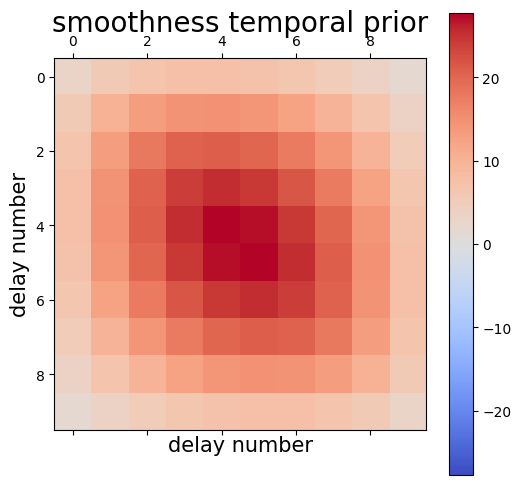

In [13]:
feature_prior = spatial_priors.SphericalPrior(nfeatures)
temporal_smoothness_prior = temporal_priors.SmoothnessPrior(delays=delays, order=2, wishart=False)
ax = symmatshow(temporal_smoothness_prior.get_prior())
ax.set_title('smoothness temporal prior', fontsize=20)
ax.set_ylabel('delay number', fontsize=15)
ax.set_xlabel('delay number', fontsize=15)

In [14]:
fit_smoothness = models.estimate_stem_wmvnp([Xtrain], Ytrain, 
                                            [Xtest],Ytest,
                                            feature_priors=[feature_prior],
                                            temporal_prior=temporal_smoothness_prior,
                                            ridges=np.logspace(0,4,10),
                                            folds=(1,5),
                                            performance=True,
                                            population_optimal=False,
                                            verbosity=2)

1/1: temporal 1/1=0.000, features 1/1=(1.0000, )
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0917, (25,50,75)pctl=(0.0278,0.0832,0.1431),(0.0<r>0.5): (2302,000)
lambda 02:    2.783, mean=0.0922, (25,50,75)pctl=(0.0281,0.0837,0.1435),(0.0<r>0.5): (2305,000)
lambda 03:    7.743, mean=0.0955, (25,50,75)pctl=(0.0301,0.0865,0.1478),(0.0<r>0.5): (2319,000)
lambda 04:   21.544, mean=0.1149, (25,50,75)pctl=(0.0437,0.1035,0.1736),(0.0<r>0.5): (2406,000)
lambda 05:   59.948, mean=0.1734, (25,50,75)pctl=(0.0848,0.1564,0.2523),(0.0<r>0.5): (2563,008)
lambda 06:  166.810, mean=0.2448, (25,50,75)pctl=(0.1346,0.2283,0.3481),(0.0<r>0.5): (2632,107)
lambda 07:  464.159, mean=0.2797, (25,50,75)pctl=(0.1602,0.2643,0.3861),(0.0<r>0.5): (2638,234)
lambda 08: 1291.550, mean=0.2767, (25,50,75)pctl=(0.1573,0.2627,0.3859),(0.0<r>0.5): (2633,234)
lambda 09: 3593.814, mean=0.2590, (25,50,75)pctl=(0.1466,0.2468,0.3655),(0.0<r>0.5): (2619,141)
lambda 10: 10000.000, mean=0.2316, (25,50,75)pc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


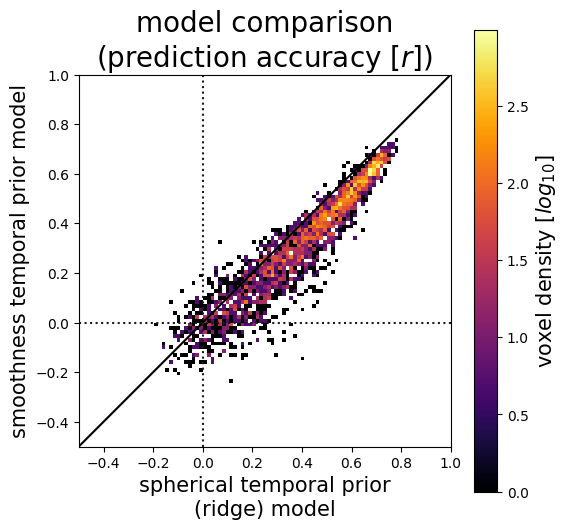

In [15]:
ax = plot_model_2dhist_comparison(np.nan_to_num(fit_spherical['performance'].squeeze()),
                                  np.nan_to_num(fit_smoothness['performance'].squeeze()),
                                  'spherical temporal prior\n(ridge)', 'smoothness temporal prior')

Text(0.5, 0, 'delay number')

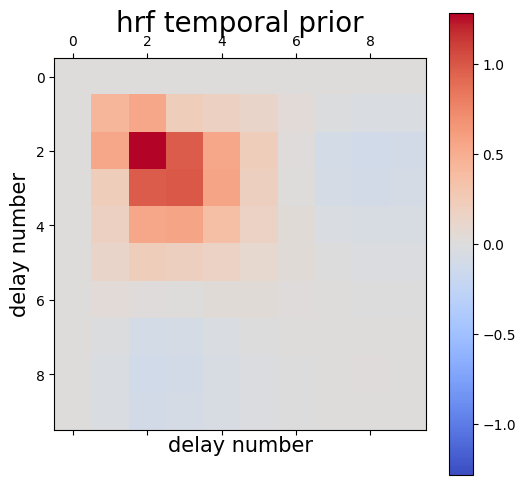

In [16]:
feature_prior = spatial_priors.SphericalPrior(nfeatures)
temporal_hrf_prior = temporal_priors.HRFPrior(delays=delays)
ax = symmatshow(temporal_hrf_prior.get_prior())

ax.set_title('hrf temporal prior', fontsize=20)
ax.set_ylabel('delay number', fontsize=15)
ax.set_xlabel('delay number', fontsize=15)

In [17]:
fit_hrf = models.estimate_stem_wmvnp([Xtrain], Ytrain, 
                                     [Xtest], Ytest,
                                     feature_priors=[feature_prior],
                                     temporal_prior=temporal_hrf_prior,
                                     ridges=np.logspace(0,4,10),
                                     folds=(1, 5),
                                     performance=True,
                                     population_optimal=False,
                                     verbosity=2)

1/1: temporal 1/1=0.000, features 1/1=(1.0000, )
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1236, (25,50,75)pctl=(0.0416,0.1036,0.1909),(0.0<r>0.5): (2367,003)
lambda 02:    2.783, mean=0.1356, (25,50,75)pctl=(0.0464,0.1132,0.2082),(0.0<r>0.5): (2395,014)
lambda 03:    7.743, mean=0.1756, (25,50,75)pctl=(0.0657,0.1483,0.2681),(0.0<r>0.5): (2460,055)
lambda 04:   21.544, mean=0.2324, (25,50,75)pctl=(0.0992,0.2081,0.3470),(0.0<r>0.5): (2525,215)
lambda 05:   59.948, mean=0.2716, (25,50,75)pctl=(0.1274,0.2517,0.4022),(0.0<r>0.5): (2579,353)
lambda 06:  166.810, mean=0.3016, (25,50,75)pctl=(0.1501,0.2893,0.4440),(0.0<r>0.5): (2592,460)
lambda 07:  464.159, mean=0.3149, (25,50,75)pctl=(0.1657,0.3086,0.4582),(0.0<r>0.5): (2608,493)
lambda 08: 1291.550, mean=0.2947, (25,50,75)pctl=(0.1583,0.2901,0.4263),(0.0<r>0.5): (2589,358)
lambda 09: 3593.814, mean=0.2518, (25,50,75)pctl=(0.1316,0.2412,0.3646),(0.0<r>0.5): (2556,189)
lambda 10: 10000.000, mean=0.2247, (25,50,75)pc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


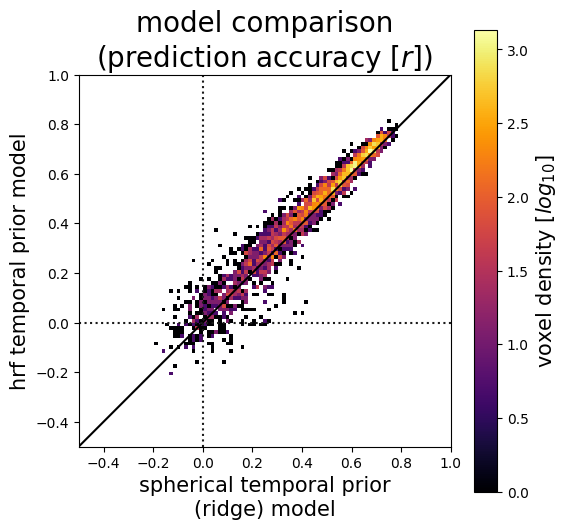

In [18]:
ax = plot_model_2dhist_comparison(np.nan_to_num(fit_spherical['performance'].squeeze()),
                                  np.nan_to_num(fit_hrf['performance'].squeeze()),
                                  'spherical temporal prior\n(ridge)', 'hrf temporal prior')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


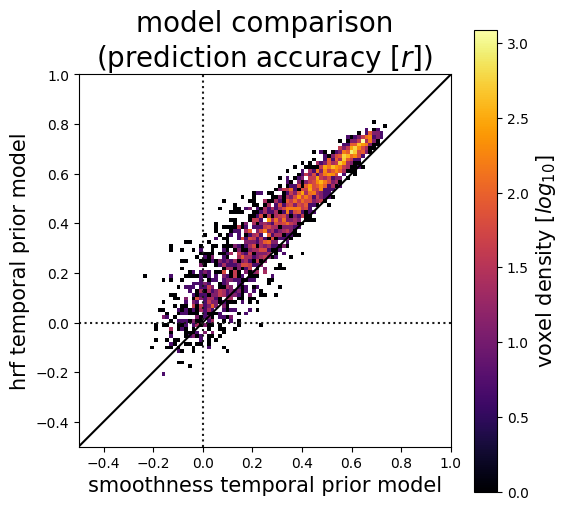

In [19]:
ax = plot_model_2dhist_comparison(np.nan_to_num(fit_smoothness['performance'].squeeze()),
                                  np.nan_to_num(fit_hrf['performance'].squeeze()),
                                  'smoothness temporal prior', 'hrf temporal prior')

For a great description of Gaussian Processes and their relationship to Gaussian Kernels: https://distill.pub/2019/visual-exploration-gaussian-processes/

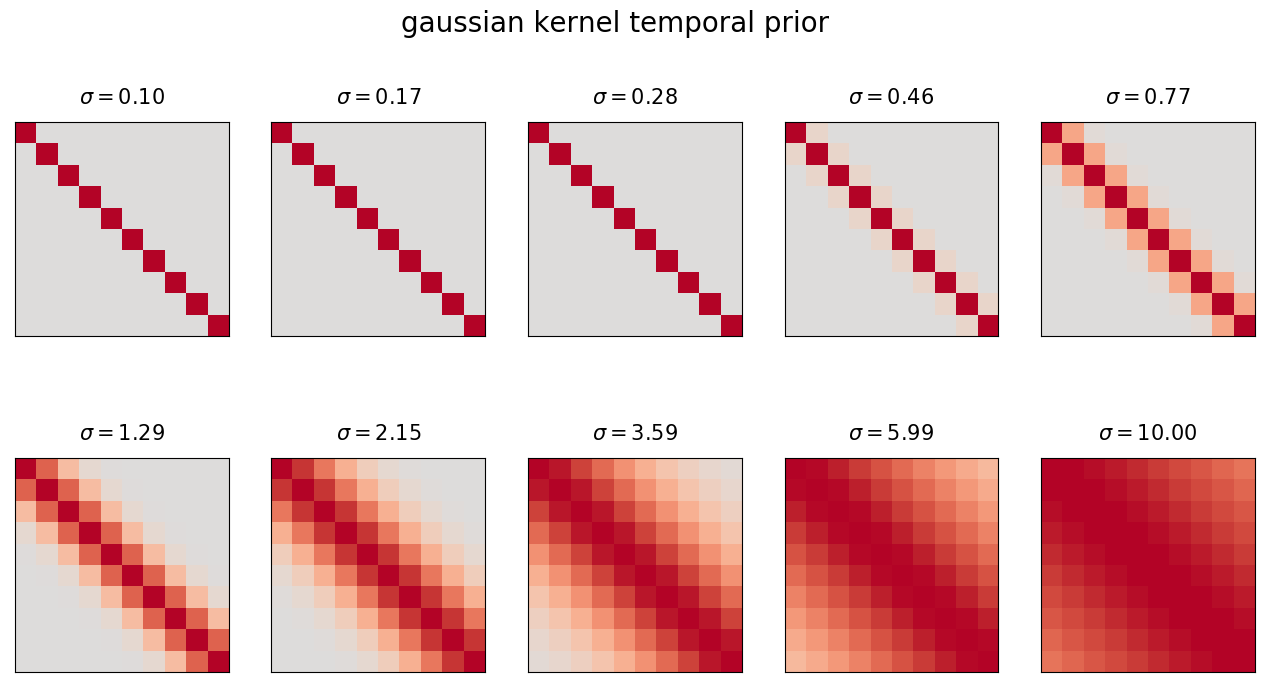

In [21]:
feature_prior = spatial_priors.SphericalPrior(nfeatures)
sigmas = np.logspace(-1,1,10)
temporal_gaussproc_prior = temporal_priors.GaussianKernelPrior(delays=delays, hhparams=sigmas)

fig = plt.figure(figsize=(16, 8))

for sdx, sigma in enumerate(sigmas):
    ax = fig.add_subplot(2,5,sdx+1)
    symmatshow(temporal_gaussproc_prior.get_prior(hhparam=sigma), ax=ax, cbar=False)
    ax.set_title('$\sigma = %02.02f$'%sigma, fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.suptitle('gaussian kernel temporal prior', fontsize=20)

In [30]:
fit_gp = models.estimate_stem_wmvnp([Xtrain], Ytrain, 
                                    [Xtest],Ytest,
                                    feature_priors=[feature_prior],
                                    temporal_prior=temporal_gaussproc_prior,
                                    ridges=np.logspace(0,4,10),
                                    folds=(1,5),
                                    performance=True,
                                    population_optimal=False,
                                    verbosity=2)

1/10: temporal 1/10=0.100, features 1/1=(1.0000, )
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2024, (25,50,75)pctl=(0.0830,0.1698,0.3039),(0.0<r>0.5): (2551,120)
lambda 02:    2.783, mean=0.2025, (25,50,75)pctl=(0.0831,0.1699,0.3040),(0.0<r>0.5): (2551,120)
lambda 03:    7.743, mean=0.2029, (25,50,75)pctl=(0.0832,0.1704,0.3044),(0.0<r>0.5): (2551,122)
lambda 04:   21.544, mean=0.2059, (25,50,75)pctl=(0.0847,0.1736,0.3086),(0.0<r>0.5): (2563,130)
lambda 05:   59.948, mean=0.2202, (25,50,75)pctl=(0.0915,0.1901,0.3291),(0.0<r>0.5): (2578,174)
lambda 06:  166.810, mean=0.2537, (25,50,75)pctl=(0.1124,0.2292,0.3781),(0.0<r>0.5): (2598,284)
lambda 07:  464.159, mean=0.2772, (25,50,75)pctl=(0.1354,0.2591,0.4077),(0.0<r>0.5): (2589,355)
lambda 08: 1291.550, mean=0.2639, (25,50,75)pctl=(0.1294,0.2490,0.3794),(0.0<r>0.5): (2587,266)
lambda 09: 3593.814, mean=0.2351, (25,50,75)pctl=(0.1163,0.2163,0.3383),(0.0<r>0.5): (2577,150)
lambda 10: 10000.000, mean=0.2176, (25,50,75)

lambda 01:    1.000, mean=0.2103, (25,50,75)pctl=(0.0855,0.1785,0.3268),(0.0<r>0.5): (2530,131)
lambda 02:    2.783, mean=0.2104, (25,50,75)pctl=(0.0855,0.1786,0.3269),(0.0<r>0.5): (2530,131)
lambda 03:    7.743, mean=0.2108, (25,50,75)pctl=(0.0858,0.1791,0.3274),(0.0<r>0.5): (2530,132)
lambda 04:   21.544, mean=0.2134, (25,50,75)pctl=(0.0870,0.1815,0.3317),(0.0<r>0.5): (2533,144)
lambda 05:   59.948, mean=0.2261, (25,50,75)pctl=(0.0924,0.1967,0.3508),(0.0<r>0.5): (2544,188)
lambda 06:  166.810, mean=0.2555, (25,50,75)pctl=(0.1109,0.2359,0.3942),(0.0<r>0.5): (2559,270)
lambda 07:  464.159, mean=0.2746, (25,50,75)pctl=(0.1306,0.2607,0.4164),(0.0<r>0.5): (2583,303)
lambda 08: 1291.550, mean=0.2630, (25,50,75)pctl=(0.1309,0.2493,0.3924),(0.0<r>0.5): (2579,237)
lambda 09: 3593.814, mean=0.2315, (25,50,75)pctl=(0.1123,0.2148,0.3439),(0.0<r>0.5): (2560,114)
lambda 10: 10000.000, mean=0.2132, (25,50,75)pctl=(0.0984,0.1957,0.3194),(0.0<r>0.5): (2539,068)
train fold  5/5: ntrain=2880, ntest=720

train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1895, (25,50,75)pctl=(0.0738,0.1603,0.2885),(0.0<r>0.5): (2520,065)
lambda 02:    2.783, mean=0.1896, (25,50,75)pctl=(0.0738,0.1604,0.2886),(0.0<r>0.5): (2520,065)
lambda 03:    7.743, mean=0.1900, (25,50,75)pctl=(0.0740,0.1608,0.2892),(0.0<r>0.5): (2521,067)
lambda 04:   21.544, mean=0.1928, (25,50,75)pctl=(0.0758,0.1636,0.2936),(0.0<r>0.5): (2525,075)
lambda 05:   59.948, mean=0.2063, (25,50,75)pctl=(0.0836,0.1771,0.3141),(0.0<r>0.5): (2538,108)
lambda 06:  166.810, mean=0.2397, (25,50,75)pctl=(0.1021,0.2188,0.3638),(0.0<r>0.5): (2562,210)
lambda 07:  464.159, mean=0.2692, (25,50,75)pctl=(0.1265,0.2596,0.4027),(0.0<r>0.5): (2573,271)
lambda 08: 1291.550, mean=0.2595, (25,50,75)pctl=(0.1321,0.2522,0.3789),(0.0<r>0.5): (2571,200)
lambda 09: 3593.814, mean=0.2269, (25,50,75)pctl=(0.1158,0.2185,0.3269),(0.0<r>0.5): (2551,102)
lambda 10: 10000.000, mean=0.2073, (25,50,75)pctl=(0.1043,0.1958,0.2975),(0.0<r>0.5): (2532,050)

lambda 10: 10000.000, mean=0.2081, (25,50,75)pctl=(0.1098,0.2008,0.2994),(0.0<r>0.5): (2537,028)
train fold  3/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1044, (25,50,75)pctl=(0.0376,0.0904,0.1591),(0.0<r>0.5): (2346,000)
lambda 02:    2.783, mean=0.1061, (25,50,75)pctl=(0.0384,0.0918,0.1610),(0.0<r>0.5): (2349,000)
lambda 03:    7.743, mean=0.1176, (25,50,75)pctl=(0.0451,0.1000,0.1778),(0.0<r>0.5): (2390,001)
lambda 04:   21.544, mean=0.1622, (25,50,75)pctl=(0.0710,0.1409,0.2365),(0.0<r>0.5): (2512,017)
lambda 05:   59.948, mean=0.2283, (25,50,75)pctl=(0.1151,0.2039,0.3248),(0.0<r>0.5): (2613,124)
lambda 06:  166.810, mean=0.2604, (25,50,75)pctl=(0.1364,0.2372,0.3709),(0.0<r>0.5): (2619,226)
lambda 07:  464.159, mean=0.2650, (25,50,75)pctl=(0.1363,0.2458,0.3796),(0.0<r>0.5): (2609,265)
lambda 08: 1291.550, mean=0.2458, (25,50,75)pctl=(0.1228,0.2281,0.3612),(0.0<r>0.5): (2579,169)
lambda 09: 3593.814, mean=0.2060, (25,50,75)pctl=(0.0996,0.1857,0.3078),(0.0<r>0.5): (2541,043)

train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0882, (25,50,75)pctl=(0.0279,0.0796,0.1431),(0.0<r>0.5): (2287,000)
lambda 02:    2.783, mean=0.0904, (25,50,75)pctl=(0.0299,0.0816,0.1457),(0.0<r>0.5): (2296,000)
lambda 03:    7.743, mean=0.1043, (25,50,75)pctl=(0.0385,0.0938,0.1629),(0.0<r>0.5): (2373,000)
lambda 04:   21.544, mean=0.1526, (25,50,75)pctl=(0.0736,0.1382,0.2242),(0.0<r>0.5): (2530,000)
lambda 05:   59.948, mean=0.2250, (25,50,75)pctl=(0.1294,0.2029,0.3113),(0.0<r>0.5): (2630,058)
lambda 06:  166.810, mean=0.2696, (25,50,75)pctl=(0.1605,0.2478,0.3690),(0.0<r>0.5): (2642,191)
lambda 07:  464.159, mean=0.2724, (25,50,75)pctl=(0.1579,0.2539,0.3811),(0.0<r>0.5): (2641,219)
lambda 08: 1291.550, mean=0.2519, (25,50,75)pctl=(0.1357,0.2386,0.3582),(0.0<r>0.5): (2617,152)
lambda 09: 3593.814, mean=0.2206, (25,50,75)pctl=(0.1142,0.2089,0.3162),(0.0<r>0.5): (2574,050)
lambda 10: 10000.000, mean=0.1813, (25,50,75)pctl=(0.0971,0.1758,0.2612),(0.0<r>0.5): (2549,000)

lambda 01:    1.000, mean=0.1006, (25,50,75)pctl=(0.0359,0.0917,0.1581),(0.0<r>0.5): (2330,000)
lambda 02:    2.783, mean=0.1037, (25,50,75)pctl=(0.0375,0.0947,0.1622),(0.0<r>0.5): (2344,000)
lambda 03:    7.743, mean=0.1215, (25,50,75)pctl=(0.0497,0.1124,0.1852),(0.0<r>0.5): (2406,000)
lambda 04:   21.544, mean=0.1717, (25,50,75)pctl=(0.0888,0.1592,0.2498),(0.0<r>0.5): (2553,000)
lambda 05:   59.948, mean=0.2317, (25,50,75)pctl=(0.1423,0.2185,0.3178),(0.0<r>0.5): (2631,016)
lambda 06:  166.810, mean=0.2670, (25,50,75)pctl=(0.1703,0.2532,0.3639),(0.0<r>0.5): (2648,097)
lambda 07:  464.159, mean=0.2664, (25,50,75)pctl=(0.1596,0.2509,0.3709),(0.0<r>0.5): (2641,116)
lambda 08: 1291.550, mean=0.2460, (25,50,75)pctl=(0.1332,0.2336,0.3543),(0.0<r>0.5): (2621,070)
lambda 09: 3593.814, mean=0.2097, (25,50,75)pctl=(0.1085,0.1994,0.3143),(0.0<r>0.5): (2574,008)
lambda 10: 10000.000, mean=0.1643, (25,50,75)pctl=(0.0812,0.1566,0.2482),(0.0<r>0.5): (2504,000)
train fold  5/5: ntrain=2880, ntest=720

lambda 01:   21.544, mean=0.0739, (25,50,75)pctl=(0.0716,0.0739,0.0761),(0.0<r>0.5): (002,000)
2 responses: ridge=   21.544, temporal=1.292, spatial=(1.000) perf=0.0739
lambda 01: 1291.550, mean=0.2255, (25,50,75)pctl=(0.2255,0.2255,0.2255),(0.0<r>0.5): (001,000)
1 responses: ridge= 1291.550, temporal=0.278, spatial=(1.000) perf=0.2255
lambda 01:  464.159, mean=0.2492, (25,50,75)pctl=(0.1903,0.2676,0.3364),(0.0<r>0.5): (043,000)
45 responses: ridge=  464.159, temporal=5.995, spatial=(1.000) perf=0.2492
lambda 01:  166.810, mean=0.5262, (25,50,75)pctl=(0.5573,0.5903,0.6351),(0.0<r>0.5): (009,007)
9 responses: ridge=  166.810, temporal=1.292, spatial=(1.000) perf=0.5262
lambda 01:  166.810, mean=0.0811, (25,50,75)pctl=(-0.0052,0.0809,0.1646),(0.0<r>0.5): (297,000)
404 responses: ridge=  166.810, temporal=10.000, spatial=(1.000) perf=0.0811
lambda 01:   59.948, mean=0.0428, (25,50,75)pctl=(-0.0404,0.0160,0.1111),(0.0<r>0.5): (019,000)
29 responses: ridge=   59.948, temporal=3.594, spatial

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


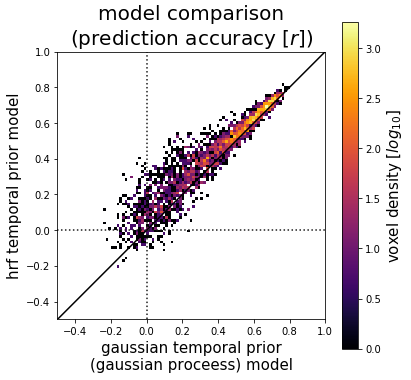

In [51]:
ax = plot_model_2dhist_comparison(np.nan_to_num(fit_gp['performance'].squeeze()),
                                  np.nan_to_num(fit_hrf['performance'].squeeze()),
                                  'gaussian temporal prior\n(gaussian proceess)', 'hrf temporal prior')

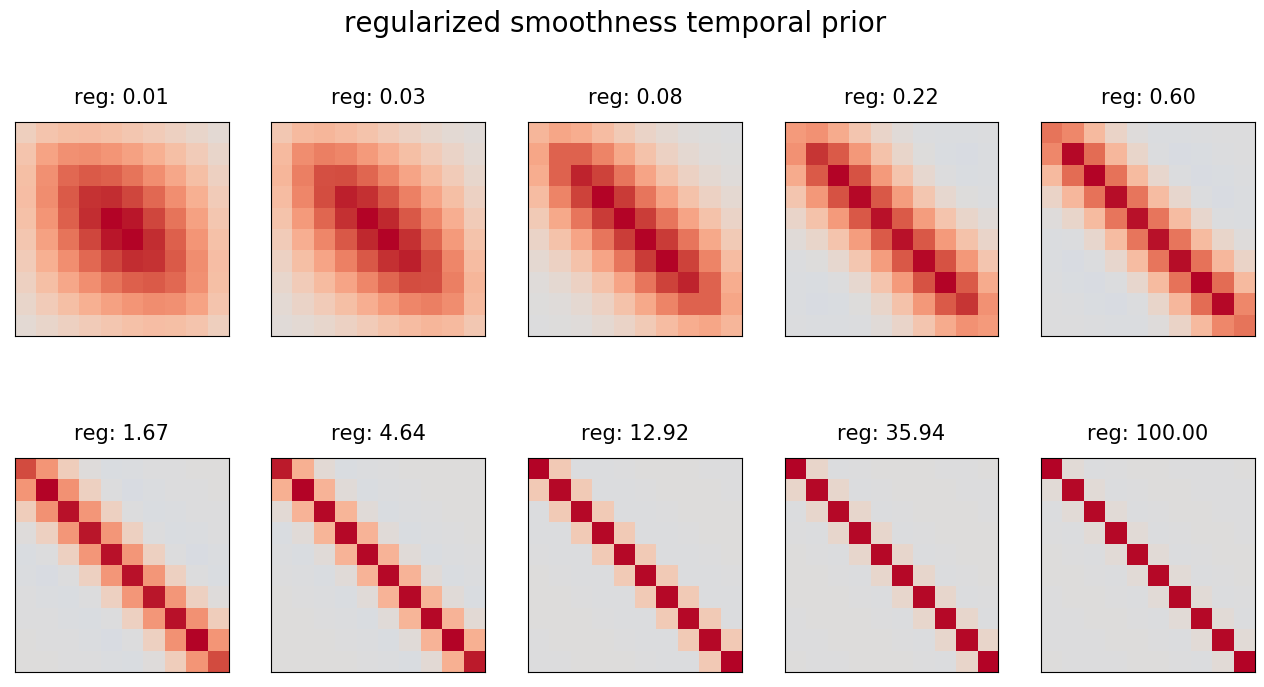

In [23]:
feature_prior = spatial_priors.SphericalPrior(nfeatures)
smoothness_penalty = np.logspace(-2,2,10)
temporal_regsmooth_prior = temporal_priors.SmoothnessPrior(delays=delays, order=2, 
                                                           wishart=True,
                                                           hhparams=smoothness_penalty)

fig = plt.figure(figsize=(16, 8))

for sdx, hhparam in enumerate(smoothness_penalty):
    ax = fig.add_subplot(2,5,sdx+1)
    symmatshow(temporal_regsmooth_prior.get_prior(hhparam=hhparam), ax=ax, cbar=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('reg: %02.02f'%hhparam, fontsize=15)
    fig.suptitle('regularized smoothness temporal prior', fontsize=20)    

In [33]:
fit_regsmo = models.estimate_stem_wmvnp([Xtrain], Ytrain, 
                                        [Xtest],Ytest,
                                        feature_priors=[feature_prior],
                                        temporal_prior=temporal_regsmooth_prior,
                                        ridges=np.logspace(0,4,10),
                                        folds=(1,5),
                                        performance=True,
                                        population_optimal=False,
                                        verbosity=2)

1/10: temporal 1/10=0.010, features 1/1=(1.0000, )
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1108, (25,50,75)pctl=(0.0462,0.0970,0.1643),(0.0<r>0.5): (2416,000)
lambda 02:    2.783, mean=0.1114, (25,50,75)pctl=(0.0466,0.0977,0.1651),(0.0<r>0.5): (2420,000)
lambda 03:    7.743, mean=0.1156, (25,50,75)pctl=(0.0490,0.1011,0.1704),(0.0<r>0.5): (2431,001)
lambda 04:   21.544, mean=0.1387, (25,50,75)pctl=(0.0640,0.1207,0.2019),(0.0<r>0.5): (2496,005)
lambda 05:   59.948, mean=0.2011, (25,50,75)pctl=(0.1057,0.1802,0.2826),(0.0<r>0.5): (2603,033)
lambda 06:  166.810, mean=0.2642, (25,50,75)pctl=(0.1500,0.2450,0.3686),(0.0<r>0.5): (2633,176)
lambda 07:  464.159, mean=0.2897, (25,50,75)pctl=(0.1654,0.2687,0.4037),(0.0<r>0.5): (2636,298)
lambda 08: 1291.550, mean=0.2895, (25,50,75)pctl=(0.1578,0.2727,0.4150),(0.0<r>0.5): (2635,306)
lambda 09: 3593.814, mean=0.2703, (25,50,75)pctl=(0.1461,0.2580,0.3902),(0.0<r>0.5): (2616,222)
lambda 10: 10000.000, mean=0.2327, (25,50,75)

lambda 01:    1.000, mean=0.1377, (25,50,75)pctl=(0.0578,0.1225,0.2051),(0.0<r>0.5): (2464,002)
lambda 02:    2.783, mean=0.1385, (25,50,75)pctl=(0.0585,0.1231,0.2059),(0.0<r>0.5): (2466,002)
lambda 03:    7.743, mean=0.1439, (25,50,75)pctl=(0.0620,0.1280,0.2127),(0.0<r>0.5): (2485,005)
lambda 04:   21.544, mean=0.1708, (25,50,75)pctl=(0.0810,0.1540,0.2479),(0.0<r>0.5): (2531,019)
lambda 05:   59.948, mean=0.2306, (25,50,75)pctl=(0.1214,0.2099,0.3292),(0.0<r>0.5): (2606,114)
lambda 06:  166.810, mean=0.2793, (25,50,75)pctl=(0.1543,0.2582,0.3954),(0.0<r>0.5): (2635,265)
lambda 07:  464.159, mean=0.2916, (25,50,75)pctl=(0.1639,0.2707,0.4137),(0.0<r>0.5): (2636,341)
lambda 08: 1291.550, mean=0.2821, (25,50,75)pctl=(0.1551,0.2659,0.4021),(0.0<r>0.5): (2626,298)
lambda 09: 3593.814, mean=0.2500, (25,50,75)pctl=(0.1346,0.2335,0.3560),(0.0<r>0.5): (2603,158)
lambda 10: 10000.000, mean=0.2000, (25,50,75)pctl=(0.0997,0.1809,0.2904),(0.0<r>0.5): (2539,032)
train fold  5/5: ntrain=2880, ntest=720

lambda 01:    1.000, mean=0.1798, (25,50,75)pctl=(0.0813,0.1535,0.2614),(0.0<r>0.5): (2541,038)
lambda 02:    2.783, mean=0.1805, (25,50,75)pctl=(0.0817,0.1544,0.2626),(0.0<r>0.5): (2543,040)
lambda 03:    7.743, mean=0.1855, (25,50,75)pctl=(0.0851,0.1587,0.2715),(0.0<r>0.5): (2544,047)
lambda 04:   21.544, mean=0.2089, (25,50,75)pctl=(0.1003,0.1796,0.3012),(0.0<r>0.5): (2578,094)
lambda 05:   59.948, mean=0.2514, (25,50,75)pctl=(0.1295,0.2250,0.3602),(0.0<r>0.5): (2603,210)
lambda 06:  166.810, mean=0.2800, (25,50,75)pctl=(0.1478,0.2611,0.4022),(0.0<r>0.5): (2624,310)
lambda 07:  464.159, mean=0.2943, (25,50,75)pctl=(0.1564,0.2804,0.4289),(0.0<r>0.5): (2611,393)
lambda 08: 1291.550, mean=0.2908, (25,50,75)pctl=(0.1562,0.2828,0.4185),(0.0<r>0.5): (2601,354)
lambda 09: 3593.814, mean=0.2616, (25,50,75)pctl=(0.1418,0.2536,0.3783),(0.0<r>0.5): (2584,203)
lambda 10: 10000.000, mean=0.2281, (25,50,75)pctl=(0.1177,0.2176,0.3342),(0.0<r>0.5): (2557,060)
train fold  3/5: ntrain=2880, ntest=720

lambda 04:   21.544, mean=0.2192, (25,50,75)pctl=(0.1033,0.1923,0.3187),(0.0<r>0.5): (2586,128)
lambda 05:   59.948, mean=0.2498, (25,50,75)pctl=(0.1267,0.2260,0.3608),(0.0<r>0.5): (2601,204)
lambda 06:  166.810, mean=0.2721, (25,50,75)pctl=(0.1398,0.2548,0.3956),(0.0<r>0.5): (2614,274)
lambda 07:  464.159, mean=0.2794, (25,50,75)pctl=(0.1445,0.2672,0.4047),(0.0<r>0.5): (2612,273)
lambda 08: 1291.550, mean=0.2572, (25,50,75)pctl=(0.1366,0.2492,0.3688),(0.0<r>0.5): (2593,178)
lambda 09: 3593.814, mean=0.2181, (25,50,75)pctl=(0.1124,0.2088,0.3159),(0.0<r>0.5): (2569,038)
lambda 10: 10000.000, mean=0.1946, (25,50,75)pctl=(0.0958,0.1826,0.2856),(0.0<r>0.5): (2534,015)
pop.cv.best: 464.159, mean=0.2340, (25,50,75)pctl=(0.1535,0.2732,0.4180),(0.0<r>0.5): (2650,347)
6/10: temporal 6/10=1.668, features 1/1=(1.0000, )
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2063, (25,50,75)pctl=(0.0907,0.1830,0.3085),(0.0<r>0.5): (2580,082)
lambda 02:    2.783, mean=0.2070, (25,50,75

lambda 04:   21.544, mean=0.2317, (25,50,75)pctl=(0.0987,0.1979,0.3457),(0.0<r>0.5): (2563,229)
lambda 05:   59.948, mean=0.2637, (25,50,75)pctl=(0.1166,0.2360,0.3962),(0.0<r>0.5): (2577,336)
lambda 06:  166.810, mean=0.2880, (25,50,75)pctl=(0.1386,0.2699,0.4287),(0.0<r>0.5): (2578,414)
lambda 07:  464.159, mean=0.2792, (25,50,75)pctl=(0.1410,0.2631,0.4092),(0.0<r>0.5): (2579,358)
lambda 08: 1291.550, mean=0.2459, (25,50,75)pctl=(0.1213,0.2285,0.3558),(0.0<r>0.5): (2551,216)
lambda 09: 3593.814, mean=0.2226, (25,50,75)pctl=(0.1030,0.2017,0.3286),(0.0<r>0.5): (2519,142)
lambda 10: 10000.000, mean=0.2166, (25,50,75)pctl=(0.0994,0.1947,0.3212),(0.0<r>0.5): (2508,123)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2090, (25,50,75)pctl=(0.0828,0.1829,0.3210),(0.0<r>0.5): (2521,135)
lambda 02:    2.783, mean=0.2097, (25,50,75)pctl=(0.0833,0.1838,0.3220),(0.0<r>0.5): (2521,136)
lambda 03:    7.743, mean=0.2143, (25,50,75)pctl=(0.0866,0.1898,0.3292),(0.0<r>0.5): (2528,150)

lambda 04:   21.544, mean=0.2533, (25,50,75)pctl=(0.1143,0.2306,0.3814),(0.0<r>0.5): (2581,247)
lambda 05:   59.948, mean=0.2821, (25,50,75)pctl=(0.1386,0.2716,0.4178),(0.0<r>0.5): (2592,354)
lambda 06:  166.810, mean=0.2774, (25,50,75)pctl=(0.1415,0.2697,0.4059),(0.0<r>0.5): (2596,288)
lambda 07:  464.159, mean=0.2416, (25,50,75)pctl=(0.1224,0.2282,0.3480),(0.0<r>0.5): (2584,168)
lambda 08: 1291.550, mean=0.2113, (25,50,75)pctl=(0.1020,0.1877,0.3079),(0.0<r>0.5): (2558,102)
lambda 09: 3593.814, mean=0.2033, (25,50,75)pctl=(0.0957,0.1765,0.3010),(0.0<r>0.5): (2549,080)
lambda 10: 10000.000, mean=0.2021, (25,50,75)pctl=(0.0938,0.1750,0.2997),(0.0<r>0.5): (2547,078)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2075, (25,50,75)pctl=(0.0852,0.1777,0.3140),(0.0<r>0.5): (2552,127)
lambda 02:    2.783, mean=0.2094, (25,50,75)pctl=(0.0861,0.1796,0.3167),(0.0<r>0.5): (2555,135)
lambda 03:    7.743, mean=0.2198, (25,50,75)pctl=(0.0923,0.1907,0.3323),(0.0<r>0.5): (2555,161)

lambda 07:  464.159, mean=0.2004, (25,50,75)pctl=(0.0891,0.1776,0.3023),(0.0<r>0.5): (2528,063)
lambda 08: 1291.550, mean=0.1862, (25,50,75)pctl=(0.0793,0.1620,0.2856),(0.0<r>0.5): (2506,040)
lambda 09: 3593.814, mean=0.1837, (25,50,75)pctl=(0.0777,0.1598,0.2820),(0.0<r>0.5): (2501,033)
lambda 10: 10000.000, mean=0.1833, (25,50,75)pctl=(0.0776,0.1593,0.2815),(0.0<r>0.5): (2500,032)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1991, (25,50,75)pctl=(0.0816,0.1693,0.3021),(0.0<r>0.5): (2553,101)
lambda 02:    2.783, mean=0.2038, (25,50,75)pctl=(0.0842,0.1742,0.3083),(0.0<r>0.5): (2552,117)
lambda 03:    7.743, mean=0.2232, (25,50,75)pctl=(0.0940,0.1951,0.3373),(0.0<r>0.5): (2563,173)
lambda 04:   21.544, mean=0.2574, (25,50,75)pctl=(0.1157,0.2393,0.3890),(0.0<r>0.5): (2570,261)
lambda 05:   59.948, mean=0.2682, (25,50,75)pctl=(0.1296,0.2608,0.3946),(0.0<r>0.5): (2579,251)
lambda 06:  166.810, mean=0.2423, (25,50,75)pctl=(0.1245,0.2332,0.3508),(0.0<r>0.5): (2580,134)

lambda 01:  166.810, mean=0.6509, (25,50,75)pctl=(0.6064,0.6572,0.7059),(0.0<r>0.5): (106,101)
106 responses: ridge=  166.810, temporal=1.668, spatial=(1.000) perf=0.6509
lambda 01:  464.159, mean=0.2835, (25,50,75)pctl=(0.1914,0.2297,0.3486),(0.0<r>0.5): (003,000)
3 responses: ridge=  464.159, temporal=12.915, spatial=(1.000) perf=0.2835
lambda 01:  166.810, mean=0.5166, (25,50,75)pctl=(0.4232,0.5948,0.6364),(0.0<r>0.5): (011,007)
11 responses: ridge=  166.810, temporal=0.599, spatial=(1.000) perf=0.5166
lambda 01: 1291.550, mean=0.2162, (25,50,75)pctl=(0.2162,0.2162,0.2162),(0.0<r>0.5): (001,000)
1 responses: ridge= 1291.550, temporal=4.642, spatial=(1.000) perf=0.2162
lambda 01: 3593.814, mean=0.1627, (25,50,75)pctl=(0.1627,0.1627,0.1627),(0.0<r>0.5): (001,000)
1 responses: ridge= 3593.814, temporal=0.215, spatial=(1.000) perf=0.1627
Total duration 123.2587[mins]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


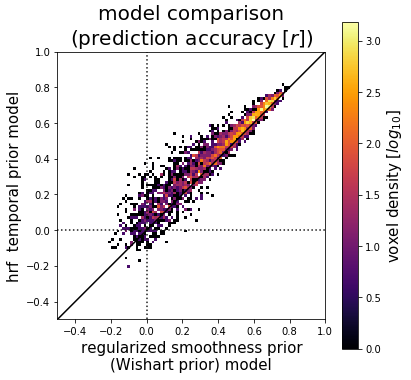

In [53]:
ax = plot_model_2dhist_comparison(np.nan_to_num(fit_regsmo['performance'].squeeze()),
                                  np.nan_to_num(fit_hrf['performance'].squeeze()),
                                  'regularized smoothness prior\n(Wishart prior)', 
                                  'hrf  temporal prior')